<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Replicating the Ensemble strategy and Exploring Environment Engineering

This notebook replicates the results of the Ensemble Strategy applied to portfolio optimization presended in [this paper](https://dl.acm.org/doi/abs/10.1145/3383455.3422540?casa_token=O4He1WYqnLIAAAAA:S2dYJYYVWRsgYsND1ymR_fECKZ5PUHwgizHDag3YhCBsf6WezzS7GnfyVtJvN9-X-510g1dJ_7d4aA). This notebook also includes codes for extra featuring engineering which we have shown to help the agent learn better.

The following sections of codes in this notebook are taken from the open-source frame work, [FinRL](https://github.com/AI4Finance-Foundation/FinRL/blob/master/README.md)



*   Stock data acquisition
*   Hyperparameters definition for various DRL agent (learning rates, batch sizes, buffer size..). Taken from this [notebook](https://github.com/AI4Finance-Foundation/FinRL/blob/master/examples/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb)

*   Environment parameters (initial balance, buying/selling costs, validation period...). Taken from this[ notebook](https://github.com/AI4Finance-Foundation/FinRL/blob/master/examples/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb)
*   Sharpe Ratio computation

*   Dow Industrial Average data acquisition and processing (Benchmarking)


Since our main purpose is to investigate the effect of encoding various information in the enviornment, we choosed to employ the Ensemble model from FinRL rather than implementing on our own.









# Problem Definition
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing the environment at a specific time stamp, taking an action, receving a reward based on change in portfolio value, and arriving in a new envrionment.

The **Envrionment** employed in the paper involves the following:

Base Environment

*   b$_{t}$∈R: The available balance for us to trade at time step t
*   p$_{t}$∈R$^{30}$: Adjusted closed price the 30 stocks at time step t
*   h$_{t}$∈R$^{30}$: The number of shares we hold each stock

Additional Features: These are the indicators computed for each stock at time step t, reflecting different aspects of a stock. Since these indicators are common assitant to human traders, it's natrual to provide such information to RL agent to faciliate its learning.
*   RSI$_{t}$∈R$^{30}$: The Relative Strength Index for each stock at time step t
*   CCI$_{t}$∈R$^{30}$: The Commodity Channel Index of each stock at time step t
*   ADX$_{t}$∈R$^{30}$: The Average Directional Index of each stock at time step t



The **Action Space** defines how the agent interacts with the environment.

At each time step, an agent can sell, buy, or maintain its share on any of the 30 stocks.
*   A$_{t}$∈Z$^{30}$ : Where A$_{t}$[i] is the action taken on stock i.

Suppose A$_{t}$[i]=k,


*   k>0: Means the agent is buying k shares of stock i.
*   k<0: Means the agent is selling k shares of stock i.
*   k=0: Means the agent is mainting its share on stock i.

The action an agent can take on a stock is limited by its current share on the stock (i.e cannot sell more shares than it currently
 owns) and current balance (i.e cannot spend more money than it currently has for buying stocks)


## 1. Install all the packages through FinRL library
Note: The session will crash after running this block of code. It is normal. Just click re-connect and proceed to the next block.

In [1]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
#import condacolab
#condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


  Using cached wrds-3.2.0-py3-none-any.whl (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 12.3 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.6 MB/s eta 0:00:000m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 6.0 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 5.8 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 5.7 MB/s eta 0:00:00m eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Su

IOStream.flush timed out


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB ? eta 0:00:00B/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 3.4 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 10.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 566.7 kB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 408.2 kB/s eta 0:00:001m102.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 1.2 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 9.3 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 1.2 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.4 MB/s eta 0:00:000m eta 0:00:010:00:01
  Installing build depende

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

###Create Folders
The rewards and actions taken by the model at each time step will be recorded and stored as csv file in the result directory.

In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

##2. Download Stock Data
We use YahooDownloader from FinRL to obtain the stock data for the Dow's 30 company. The YahooDownloader relies on `yfinance` for downloading stock data from Yahoo Finance API.


In [6]:
print(DOW_30_TICKER) #The ticker symbol/company names we want in our profile
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-09-30' #Train from 2014-01-01 to 2019-09-30
#Validate from 2019-06-30 to 2019-09-30
TEST_START_DATE = '2019-10-01' #we want to see what happens during market crush in 2020-03
TEST_END_DATE = '2020-12-31'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (51549, 8)


In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2014-01-02,19.845715,19.893929,19.715000,17.273233,234684800,AAPL,3
1,2014-01-02,114.360001,116.190002,114.059998,86.702782,2528800,AMGN,3
2,2014-01-02,90.900002,91.080002,89.379997,76.835388,5112000,AXP,3
3,2014-01-02,136.009995,137.250000,135.509995,116.807945,3366700,BA,3
4,2014-01-02,90.410004,90.449997,89.330002,67.557640,4898000,CAT,3


#3. Replicating the Results in Paper

The paper presented a novel solution to the problem of portfolio optimization by integrating various DRL algorithms. This strategy relies on the following two assumptions:
1. Different DRL agents work better under different market dynamics. Therefore it's reasonable to apply different DRL algorithms in different quarters due to the fast-evolving nature of stock markets.
2. Trends in the stock market persist for more than 3 months. The agent that performs the best in one quarter is selected to trade for the next quarter. Therefore, ideally, if the trends persist throughout the next quarter, then we get maximized return. On the contrary, if the trends change drastically from one quarter to the next, then it's meaningless to select an agent to trade based on its previous performance.


In this section, we verified the following 3 results presented in the paper:


*  The Ensemble Strategy outperforms all other DRL agents.
*  The Ensemble Strategy outperforms the benchmark Dow Industrial Average

*  The Ensemble Strategy and all DRL agents outperformed the Dow Industrial Average during the market crash in 2020-03 due to the special feature embedded in the DRL agent that sells all holdings when the Turbulence Index exceeds a certain threshold.


In [ ]:
#Define parameters for various RL aglorithm.
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

### Preprocess Data
We use the FeatureEnginner in FinRL to process the raw stock data. The FeatureEngineer mainly does the following two tasks
* Add technical indicators, including Moving Average Convergence Divergence (MACD), Relative Strength Index (RSI), Commodity Channel Index (CCI), and Average Directional Index (ADX). They are statistics derived from the open & close prices, price history..etc of the stock and are commonly used by human traders. These indicators are computed for each stock at each time step (i.e. computed for all rows in the data frame). There is a convenient package `stock status` that computes all these indicators
* Add turbulence index. This is a measurement reflecting the stableness of the stock price.
 If the turbulence index surpasses a certain threshold, suggesting a market crash, the agent will sell all its holdings.

In [8]:
#Include the following indicators in the environment, as specified in the paper
INDICATORS=['macd','rsi_30','cci_30','dx_30']

#Preprocess the data to compute indicators from the stock data
f_e = FeatureEngineer(use_technical_indicator=True, tech_indicator_list = INDICATORS, use_turbulence=True)

processed = f_e.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0) #fill nan with 0
processed = processed.replace(np.inf,0) #fill inf with 0
print("processed :")
print(processed)

stock_dimension = len(processed.tic.unique())

env_space = 1  #balance
env_space+=2*stock_dimension #ht and pt
env_space+=len(INDICATORS)*stock_dimension #technical indicators

print(f"Stock Dimension: {stock_dimension}, State Space: {env_space}")

#define environment
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": env_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

Successfully added technical indicators
Successfully added turbulence index
processed :
             date        open        high         low       close     volume  \
0      2014-01-02   19.845715   19.893929   19.715000   17.273233  234684800   
1      2014-01-02  114.360001  116.190002  114.059998   86.702782    2528800   
2      2014-01-02   90.900002   91.080002   89.379997   76.835388    5112000   
3      2014-01-02  136.009995  137.250000  135.509995  116.807945    3366700   
4      2014-01-02   90.410004   90.449997   89.330002   67.557640    4898000   
...           ...         ...         ...         ...         ...        ...   
51093  2020-12-30  347.079987  349.010010  344.470001  329.623169    1866000   
51094  2020-12-30  216.000000  220.389999  215.649994  212.908707    8875100   
51095  2020-12-30   58.830002   58.939999   58.060001   47.539909   18259800   
51096  2020-12-30   39.520000   39.730000   39.200001   32.948395    4194300   
51097  2020-12-30   48.293331   

In [ ]:
#see the info included in the env
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
16572,2016-04-11,31.900000,32.340000,31.660000,25.512932,19707700,INTC,0,0.205726,51.654956,38.191875,10.870825,12.683743
26535,2017-08-21,39.375000,39.472500,38.777500,36.984684,105474000,AAPL,0,0.609856,56.976767,46.775842,3.372027,20.832067
22269,2017-01-19,52.549999,52.639999,52.180000,36.212402,13286100,VZ,3,0.282191,55.086690,-18.845346,9.512277,8.807421
3907,2014-07-16,38.924999,39.115002,38.384998,34.542233,7449600,NKE,2,0.268661,52.624438,45.204332,4.629724,0.000000
6589,2014-11-25,27.030001,27.299999,27.030001,20.271132,28110100,CSCO,1,0.555183,68.953627,138.908097,54.370017,0.000000


In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)


#Define agent & Train agent
ensemble_agent = DRLEnsembleAgent(df=processed,
                  train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                  val_test_period=(TEST_START_DATE,TEST_END_DATE),
                  rebalance_window=rebalance_window,
                  validation_window=validation_window,
                  **env_kwargs)
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                  PPO_model_kwargs,
                                                  DDPG_model_kwargs,
                                                  SAC_model_kwargs,
                                                  TD3_model_kwargs,
                                                  timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  199.31902490149085
======Model training from:  2014-01-01 to  2019-10-02
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
----------------------------------------
| time/                 |              |
|    fps                | 124          |
|    iterations         | 100          |
|    time_elapsed       | 4            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -41.2        |
|    explained_variance | 0.0368       |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -62.7        |
|    reward             | -0.024234606 |
|    std                | 1            |
|    value_loss         | 3.15         |
----------------------------------------
--------------------------------------
| time/         

###Result Validation - 1: Overall, the Ensemble Strategy outperforms all other DRL agents.

More specifically



*  **Before Market Crash (2020-01-02 to 2020-03-01)**: The performance of various DRL agents is indistinguishable in terms of cumulative return, with DDPG slightly outperforming other agents. However, we will later see that the Ensemble strategy distributed its investment smarter than other agents.
*  **During Market Crash (2020-03-01 to 2020-04-01)**: All agents detected the rapid drop in stock prices via the Turbulence Index and sold all their holdings at the same time. However, the Ensembled Strategy invested more in the stocks that drop less (and less in the stocks that drop more), which minimizes its loss compared with other agents.

*  **Post Market Crash (2020-04-01 and beyond)**: The Ensemble strategy recovers from the market crash more quickly than all other DRL agents. If we take a closer look at the period between 2020-04-01 and 2020-04-16, we can observe that the Ensemble Strategy made the biggest leap among all other agents. At the end of the trading period, the Ensemble Strategy outperformed the majority of DRL agents by 10%




In [ ]:
from google.colab import files

#get the validation results from each agent & ensembled
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

agents=['ensemble','a2c','ddpg','ppo','sac','td3']

for agent in agents:
  df_account_value=pd.DataFrame()
  for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
      if agent != 'ensemble' and i==rebalance_window+validation_window:
        continue
      if agent=='ensemble':
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(agent,i)) #read result of ensemble
      else:
        temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format(agent,i))
      df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
  sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
  print('{} Agent Sharpe Ratio: {}'.format(agent,sharpe))
  #keep account value for validation window only
  df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
  df_account_value.to_csv('results/account_value_{}.csv'.format(agent))
  files.download('results/account_value_{}.csv'.format(agent))


ensemble Agent Sharpe Ratio: 0.4253729958021146


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

a2c Agent Sharpe Ratio: 0.48033636352760967


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ddpg Agent Sharpe Ratio: 0.6669630236164451


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ppo Agent Sharpe Ratio: 0.5120527140262122


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

sac Agent Sharpe Ratio: 0.6126317260189766


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

td3 Agent Sharpe Ratio: 0.6855027100066634


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

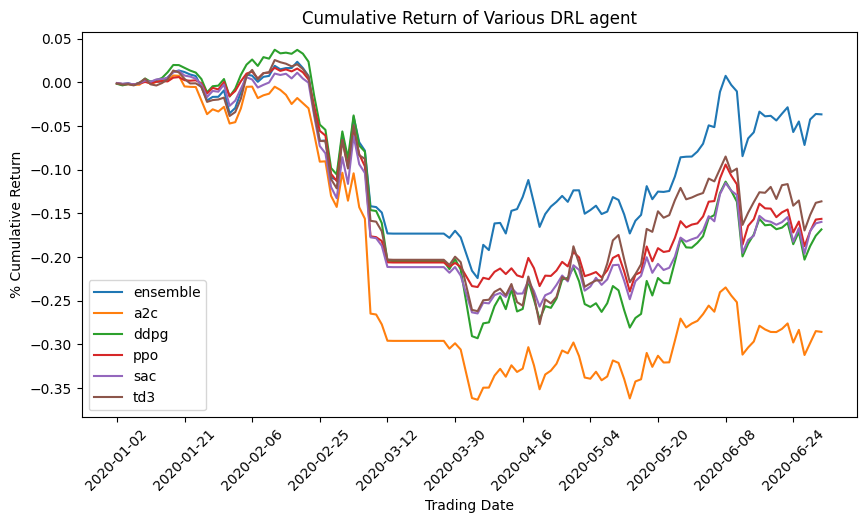

In [ ]:
#read results from csv
%matplotlib inline
labels=['ensemble','a2c','ddpg','ppo','sac','td3']
df_account_value=[]
for label in labels:
  df=pd.read_csv('results/account_value_{}.csv'.format(label))
  df.fillna(method='ffill',inplace=True) #remove Nan
  df.fillna(method='bfill',inplace=True) #remove 0
  #add column of cumulative return
  df['cumulative_return']=df['daily_return'].cumsum()
  df_account_value.append(df)

plt.figure(figsize=(10,5))
dates=df_account_value[1].date
#get 10 evenly distributed dates
key_dates=[]
for d in range(0,len(dates),len(dates)//10):
  key_dates.append(dates[d])

#align dates for ensemble
valid_dates=df_account_value[0]['date']<=dates.max()
ensemble_matched_date=df_account_value[0][valid_dates]

plt.plot(dates,ensemble_matched_date.cumulative_return,label='ensemble')
for i in range(len(df_account_value)):
  if i==0:
    continue
  plt.plot(dates,df_account_value[i].cumulative_return,label=labels[i])

plt.xticks(key_dates,rotation=45)
plt.title('Cumulative Return of Various DRL agent')
plt.xlabel('Trading Date')
plt.ylabel('% Cumulative Return')
plt.legend()
plt.show()





###Result Validation -2: The Ensemble Strategy outperforms the benchmark Dow Industrial Average (DJI)

Before the market crash, DJI and the Ensemble strategy have similar performance. During the market crash, due to the Turblance Index features, which force the agent to sell all holdings, allowed the Ensemble agent to preserve more balance, which eventually, allow it to recover faster from the crash. After the market crash, both of them recovered quickly, but the Ensemble agent consitently outperform DJI with the two curves growing further apart as we approach the end of the trading period.

In [ ]:
#account_value, date, daily_return, datadate
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value[0].loc[0,'date'],
        end = df_account_value[0].loc[len(df_account_value[0])-1,'date'])
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value[0]['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
#print("df_dji: ", df_dji)
#df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("results/df_dji+.csv")

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (188, 8)


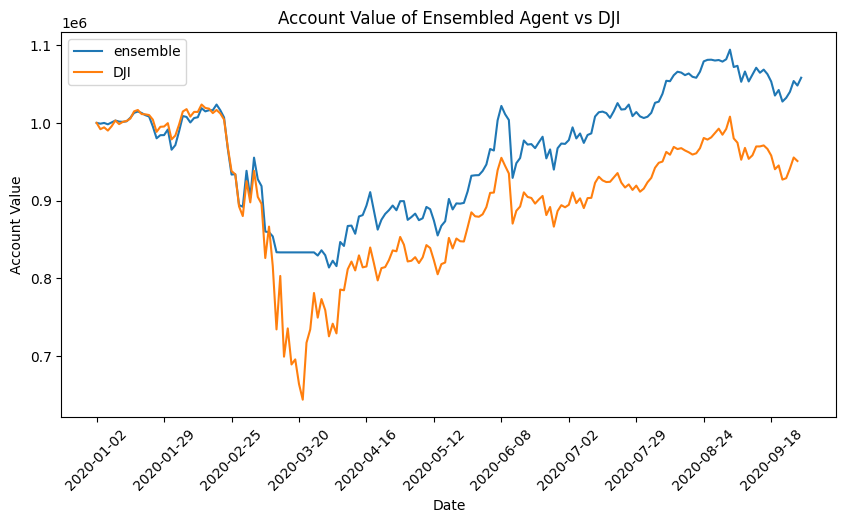

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,5))
dates=df_account_value[0].date
#get 10 evenly distributed dates
key_dates=[]
for d in range(0,len(dates),len(dates)//10):
  key_dates.append(dates[d])
plt.plot(dates,df_account_value[0].account_value,label='ensemble')
plt.plot(dates,df_dji.account_value,label='DJI')
plt.xticks(key_dates,rotation=45)
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value of Ensembled Agent vs DJI')
plt.legend()
plt.show()

###Result Validation -3: All DRL agents surived the market crash better than DJI

As we can observe, the Turbulence feature implemented in DRL agent prevented the agents from losing more money during market crash, which allow them to have more funds to recover from market crash. Throughout the market crash period from 2020-03-04 to 2020-03-30, DJI has consitently low account balance than most DRL agents and reached the valley with an extra $150k loss in account balance when compared with most agents.

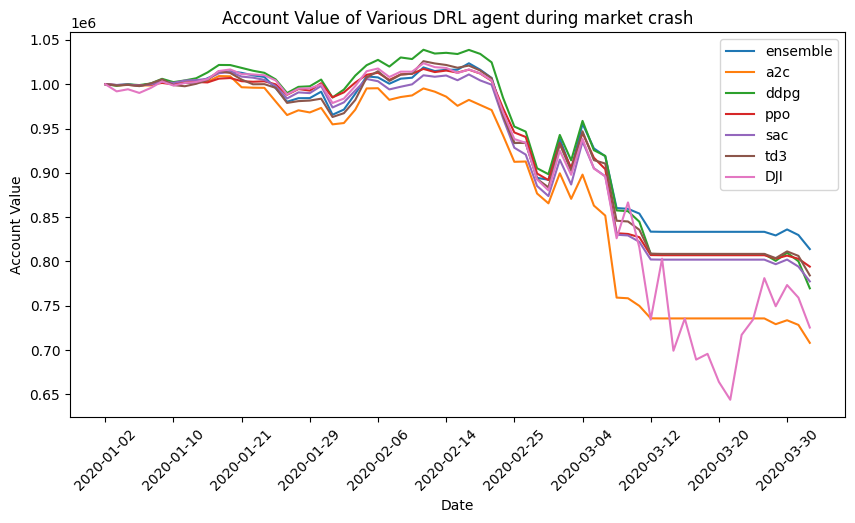

In [ ]:
##Compare performance during market crash from 2020-01-01 to 2020-04-01
df_account_value_crash=[]
for df_agent in df_account_value:
  df_account_value_crash.append(df_agent[df_agent.date<='2020-04-01'])

crash_date=dates[dates<='2020-04-01']
plt.figure(figsize=(10,5))
for i in range(len(df_account_value_crash)):
  plt.plot(crash_date,df_account_value_crash[i].account_value,label=labels[i])

key_dates=[]
for d in range(0,len(crash_date),len(crash_date)//10):
  key_dates.append(crash_date[d])

crash_dj_df=df_dji[df_dji.date<='2020-04-01']
plt.plot(crash_date,crash_dj_df.account_value,label='DJI')

plt.xticks(key_dates,rotation=45)
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value of Various DRL agent during market crash')
plt.legend()
plt.show()



#4. Compare the envrionment in the paper against our customized environment

One of the main purpose in this project is to investigate whether encoding more information into the environment will give us a better performance. The idea behind this is to see whether the agent learns better when provided with information that is usually available for human traders. Therefore, on top of the environment used in the paper, we added 6 more indicators that are widely used in porfolio optimizatio and are, what we identified as, the most useful indicators for such problem to every stock on every day. These indicators are:



*   Expotential Moving Average
*   Bollinger Band
*   Average Directional Movement Index
*   Simple Moving Average
*   Volume Ratio
*   Supertrend

We refer to the environment with the above indicator added as customized environment.

**State Space in Customized Environment**: [b$_{t}$, p$_{t}$, h$_{t}$, MACD$_{t}$, RSI$_{t}$, CCI$_{t}$,DX$_{t}$, **EMA$_{t}$, BOLL_LB$_{t}$, BOLL_UB$_{t}$, BOLL$_{t}$, ADX$_{t}$, SMA$_{t}$, VR$_{t}$, SUPERTREND$_{t}$**]


**State Space in Paper**: [b$_{t}$, p$_{t}$, h$_{t}$,MACD$_{t}$, RSI$_{t}$, CCI$_{t}$,DX$_{t}$,Turb$_{t}$]

To achieve this purpose, we trained and tested two Ensemble agents under different environments, the one presented in the paper, and the customzied environment. i.e One agent is trained & tested with more information available in its environment, and the other is trained & tested with less information available.

Theoretically, an agent should be able to learn the dynamics of the market implicity when given enough data (without explicity providing it with indicators that describes the market dynamics). However, with limited data & compute resource, we predict the agent to learn better when we do the computation beforhand and provide such information to the agent.

###1) Get the Baseline
Get the performance of the Ensemble model using the environment presented in the paper.

In [ ]:
#Get the dataset

print(DOW_30_TICKER)
TRAIN_START_DATE = '2016-01-01'
TRAIN_END_DATE = '2022-01-01' #shorten this to accelerate
#do 6 years of training & 1.5 year of testing
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2023-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [ ]:
INDICATORS=['macd','rsi_30','cci_30','dx_30']
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

stock_dimension = len(processed.tic.unique())
env_space = 1
env_space+=2*stock_dimension
env_space+=len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {env_space}")

#define environment
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": env_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}
#Define agent
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
#i.e we trade with a certain agent (e.g A2C) and validate other agents concurrently


ensemble_agent = DRLEnsembleAgent(df=processed,
                  train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                  val_test_period=(TEST_START_DATE,TEST_END_DATE),
                  rebalance_window=rebalance_window,
                  validation_window=validation_window,
                  **env_kwargs)
  #took 22 minutes for 2 extra features
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                  PPO_model_kwargs,
                                                  DDPG_model_kwargs,
                                                  SAC_model_kwargs,
                                                  TD3_model_kwargs,
                                                  timesteps_dict)


Successfully added technical indicators
Successfully added turbulence index
Stock Dimension: 29, State Space: 175
============Start Ensemble Strategy============
turbulence_threshold:  239.38658796255814
======Model training from:  2016-01-01 to  2022-01-03
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_15
--------------------------------------
| time/                 |            |
|    fps                | 133        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0.0547     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -25.2      |
|    reward             | 0.69117427 |
|    std                | 1          |
|    value_loss         | 0.639      |
-----------

In [ ]:
#write baseline result to csv
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i)) #read result of ensemble
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: {}'.format(sharpe))
  #keep account value for validation window only
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value.to_csv('results/account_value_paper_baseline.csv')

Sharpe Ratio: -0.1910828567691973


###2) Get performance of the model using customized env


In [ ]:

#Customized Indicators
INDICATORS=['macd','rsi_30','cci_30','dx_30','close_30_ema','boll_ub','boll_lb','boll','adx','close_30_sma','vr','supertrend']

In [ ]:
#run-time: 40 minutes
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
#preprocess_data(df) returns modified df
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

stock_dimension = len(processed.tic.unique())
env_space = 1
env_space+=2*stock_dimension
env_space+=len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {env_space}")


#define environment
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": env_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}
  #Define agent
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)



ensemble_agent = DRLEnsembleAgent(df=processed,
                  train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                  val_test_period=(TEST_START_DATE,TEST_END_DATE),
                  rebalance_window=rebalance_window,
                  validation_window=validation_window,
                  **env_kwargs)
  #took 22 minutes for 2 extra features
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                  PPO_model_kwargs,
                                                  DDPG_model_kwargs,
                                                  SAC_model_kwargs,
                                                  TD3_model_kwargs,
                                                  timesteps_dict)


Successfully added technical indicators
Successfully added turbulence index
Stock Dimension: 29, State Space: 407
============Start Ensemble Strategy============
turbulence_threshold:  239.38658796255814
======Model training from:  2016-01-01 to  2022-01-03
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_16
--------------------------------------
| time/                 |            |
|    fps                | 124        |
|    iterations         | 100        |
|    time_elapsed       | 4          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.1      |
|    explained_variance | 0.106      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 19.8       |
|    reward             | 0.16235371 |
|    std                | 0.999      |
|    value_loss         | 0.804      |
-----------

In [ ]:
#write customized env result to csv
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i)) #read result of ensemble
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: {}'.format(sharpe))
  #keep account value for validation window only
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value.to_csv('results/account_value_customized_env.csv')

Sharpe Ratio: 0.08339341947674846



###3) Get benchmark DJI

In [ ]:
#read results from csv
df_account_value_paper = pd.read_csv('results/account_value_paper_baseline.csv')
df_account_value_customized = pd.read_csv('results/account_value_customized_env.csv')
#account_value, date, daily_return, datadate
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value_paper.loc[0,'date'],
        end = df_account_value_paper.loc[len(df_account_value_paper)-1,'date'])
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_paper['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
#print("df_dji: ", df_dji)
#df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)


In [ ]:
print(df_account_value_paper['account_value'])

0      1.000000e+06
1      1.002189e+06
2      9.979286e+05
3      9.977591e+05
4      1.005247e+06
           ...     
121    1.021177e+06
122    1.027336e+06
123    1.035325e+06
124    1.022052e+06
125    1.017884e+06
Name: account_value, Length: 126, dtype: float64


##Results


*  The agent trained in the customized environment, with more market dynamic information provided, consistently outperforms the agent trained in the environment with less information available throughout the 1 year trading period.
*  Compared with the benchmark DJI, the agent trained in the environment presented in the paper has comparable performance, with slightly better performance in a bullish market (stock prices rising). On the contrary, the agent trained & tested in a customized environment outperforms DJI significantly under all market dynamics.

The observations align with our hypothesis that the agent will learn better with extra information about the market dynamics encoded in the environment, especially when there is limited training data.




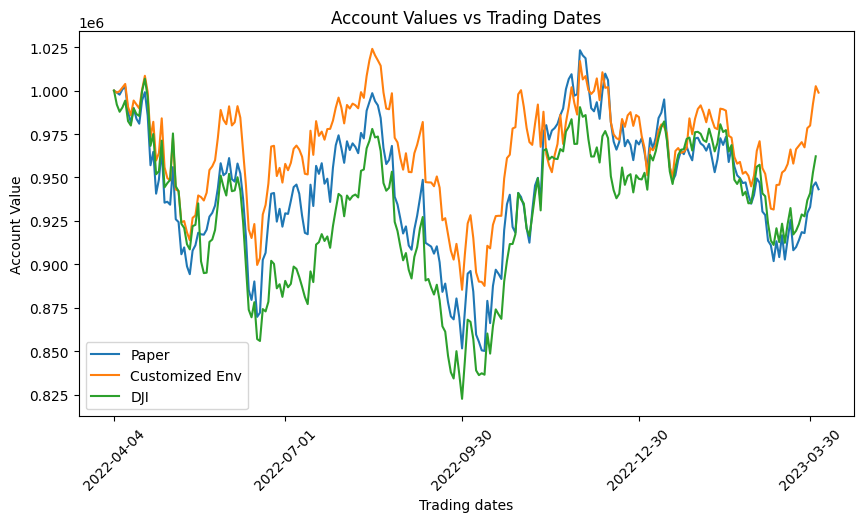

In [ ]:
%matplotlib inline
dates=df_account_value_paper['date']
#df_account_value_paper.account_value.plot(label='Paper')
#df_account_value_customized.account_value.plot(label='Customized Env')
plt.figure(figsize=(10,5))
plt.plot(dates,df_account_value_paper['account_value'],label='Paper')
plt.plot(dates,df_account_value_customized['account_value'],label='Customized Env')
plt.plot(dates,df_dji.account_value,label='DJI')
key_dates=['2022-04-04','2022-07-01','2022-09-30','2022-12-30','2023-03-30']
plt.xticks(key_dates,rotation=45)
plt.legend()
plt.title('Account Values vs Trading Dates')
plt.xlabel('Trading dates')
plt.ylabel('Account Value')
plt.show()


In [ ]:
#download results for our model & model in the paper
from google.colab import files
files.download('results/account_value_paper_baseline.csv')
files.download('results/account_value_customized_env.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#5. Investigating the effect of each indicator

In the last section, we explored the benefits of adding a set of indicators to the environment.

 In this section, we are exploring the effects of adding individual
indicator to the environment.

To do this:

 1. Firstly, we have manually defined a list of indicators that are widely used for portfolio optimization and are, what we
beleive to be, the most beneficial or valuable information for the agent.

They are

*  Exponential Moving Average
*  Bollinger Band
*  Average Directional Index
*  Simple Moving Average
*  Volume Ratio
*  Supertrend
*  Stochastic RSI
*  Triple Exponential Moving
*  Stochastic Oscillator

Ordered by human perception of their importance for portfolio optimization.

2. Secondly, we create an environment that includes one of the above indicators on top of the environment used in the paper. We do so by preprocessing the data to include the desired indicator for each stock at each time step.

For example, if we are testing the effect of including Exponential Moving Average (EMA) in the environment, then our state space would be
[b$_{t}$,p$_{t}$,h$_{t}$,RSI$_{t}$,CCI$_{t}$,ADX$_{t}$,**EMA$_{t}$**], where [b$_{t}$,p$_{t}$,h$_{t}$,RSI$_{t}$,CCI$_{t}$] is the state space presented in the paper.


3. Thirdly, we train and test the ensembled agent under this new environment.

4. Lastly, we compare the performance of the agent trained & tested under the new environment (with one additional indicator) with the agent trained & tested in the environment presented in the paper. We also compare the performance against DJI.

We repeat the above steps for each indicator mentioned in 1.


**Observations**:


*  Some indicators that we perceive as important do help RL agents to learn better. A prominent example would be the Exponential Moving Average (explain why it's useful for a problem like this) EMA, which we have identified as the most useful indicator, boosted the performance by 10% by the end of the 1-year trading period when compared with the agent trained & tested without this indicator and DJI. Notable, the agent trained with EMA outperforms the agent trained without EMA on every trading day throughout the entire trading period. Other indicators that help RL agents learn better are Bollinger Band, Simple Moving Average, and Supertrend.
*  Some popular indicators that are used by human traders undermine the performance of RL agents when added to the environment. For example, the account balance of the agent trained & tested with Triple Exponential Moving Average (TEMA) added to the environment has dropped by 10% by the end of the trading period when compared with the agent trained without TEMA added.

**Commnents**:
It is not surprising that some indicators that we believe are useful do not help the agent because some indicators work better when paired with a specific combination of indicators. Therefore, the unsatisfactory result we observe does not imply the indicator is bad for the agent and should never be included in the environment. The performance might be bad simply because it's not grouped with the appropriate indicators. However, to determine the best combination of indicators where each of them contributes to the learning of the agent requires an exhaustive search which is costly.

Another reason is that some indicators are not suitable under certain market dynamics. Experienced traders know which indicators are more significant and should be valued more heavily and which indicators should be neglected under certain market dynamics. Given the wide range of all possible states, it would be hard for the agent to learn to do so.







In [ ]:
BASE_INDICATORS=['macd','rsi_30','cci_30','dx_30']

#some indictors are grouped together e.g boll
ADDITIONAL_INDICATORS=[['close_30_ema'],['boll_ub','boll_lb','boll'],['adx'],['close_30_sma'],['vr'],['supertrend'],['stochrsi'],['trix'],['kdjk','kdjd','kdjj']]
additional_indicator_names=['Exponential Moving Average','Bollinger Band','Average Directional Index','Simple Moving Average','Volume Ratio','Supertrend','Stochastic RSI','Triple Exponential Moving Average','Stochastic Oscillator']


In [ ]:
#The main loop to test the performance of including each indicator
#should take ~ 2.5 hours
from google.colab import files
for (ctr,TECH_IND) in enumerate(ADDITIONAL_INDICATORS):
  #each time uses a different indicator from additional_indicators
  INDICATORS=BASE_INDICATORS+TECH_IND


  #Proccess the data to contain INDICATORS
  fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

  processed = fe.preprocess_data(df)
  processed = processed.copy()
  processed = processed.fillna(0)
  processed = processed.replace(np.inf,0)

  stock_dimension = len(processed.tic.unique())
  env_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension

  #define environment
  env_kwargs = {
      "hmax": 100,
      "initial_amount": 1000000,
      "buy_cost_pct": 0.001,
      "sell_cost_pct": 0.001,
      "state_space": env_space,
      "stock_dim": stock_dimension,
      "tech_indicator_list": INDICATORS,
      "action_space": stock_dimension,
      "reward_scaling": 1e-4,
      "print_verbosity":5
  }
    #Define agent
  rebalance_window = 63 # rebalance_window is the number of days to retrain the model
  validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)



  ensemble_agent = DRLEnsembleAgent(df=processed,
                    train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                    val_test_period=(TEST_START_DATE,TEST_END_DATE),
                    rebalance_window=rebalance_window,
                    validation_window=validation_window,
                    **env_kwargs)
  #run agent
  df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                    PPO_model_kwargs,
                                                    DDPG_model_kwargs,
                                                    SAC_model_kwargs,
                                                    TD3_model_kwargs,
                                                    timesteps_dict)
  #write result for this Indicator into csv
  unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
  df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

  df_account_value=pd.DataFrame()
  for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
      temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i)) #read result of ensemble
      df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
  sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
  print('Sharpe Ratio: {}'.format(sharpe))
  #keep account value for validation window only
  df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
  df_account_value.to_csv('results/account_value_{}.csv'.format(additional_indicator_names[ctr]))
  #Optional. Download the csv
  files.download('results/account_value_{}.csv'.format(additional_indicator_names[ctr]))

Successfully added technical indicators
Successfully added turbulence index
Stock Dimension: 29, State Space: 204
============Start Ensemble Strategy============
turbulence_threshold:  239.38860835269767
======Model training from:  2016-01-01 to  2022-01-03
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 131         |
|    iterations         | 100         |
|    time_elapsed       | 3           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | -1.22       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 70.7        |
|    reward             | 0.007423971 |
|    std                | 1           |
|    value_loss         | 5.81       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully added technical indicators
Successfully added turbulence index
Stock Dimension: 29, State Space: 204
============Start Ensemble Strategy============
turbulence_threshold:  239.38860835269767
======Model training from:  2016-01-01 to  2022-01-03
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_2
---------------------------------------
| time/                 |             |
|    fps                | 149         |
|    iterations         | 100         |
|    time_elapsed       | 3           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | -0.0803     |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 4.91        |
|    reward             | 0.040678915 |
|    std                | 1.01        |
|    value_loss         | 0.402      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully added technical indicators
Successfully added turbulence index
Stock Dimension: 29, State Space: 262
============Start Ensemble Strategy============
turbulence_threshold:  239.38860835269767
======Model training from:  2016-01-01 to  2022-01-03
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_3
--------------------------------------
| time/                 |            |
|    fps                | 142        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0.0721     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 56.1       |
|    reward             | -0.3019248 |
|    std                | 1          |
|    value_loss         | 2.66       |
------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#download result for each tech indicator
from google.colab import files
for ind in additional_indicator_names:
  files.download('results/account_value_{}.csv'.format(ind))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
#plot the difference between customized & paper, and customized & DJI as parallel subplots
def plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,title,label):
  #diff_account_value_paper = % difference between the account value of our model and paper's account value
  #diff_account_value_dji = % difference between the account value of our model and DJI's account value
  fig,axes=plt.subplots(nrows=2,ncols=1,sharey=True,sharex=True,figsize=(10,5),layout='constrained')
  axes[0].plot(dates,diff_account_value_paper,color='black',label=label)
  axes[0].axhline(0, color='red', linestyle='--', label='Paper')
  axes[0].fill_between(dates,diff_account_value_paper,0,where=(diff_account_value_paper>=0),color='red',alpha=0.4)
  axes[0].fill_between(dates,diff_account_value_paper,0,where=(diff_account_value_paper<0),color='lightgreen',alpha=0.4)
  #print(key_dates)
  axes[0].set_xticks(key_dates)
  axes[0].legend()
  axes[0].set_xlabel('Trading dates')
  axes[0].set_ylabel('% Difference in Account Value')

  axes[1].plot(dates,diff_account_value_dji,color='black',label=label)
  axes[1].axhline(0, color='red', linestyle='--', label='DJI')
  axes[1].fill_between(dates,diff_account_value_dji,0,where=(diff_account_value_dji>=0),color='red',alpha=0.4)
  axes[1].fill_between(dates,diff_account_value_dji,0,where=(diff_account_value_dji<0),color='lightgreen',alpha=0.4)
  axes[1].set_xticks(key_dates)
  axes[1].legend()
  axes[1].set_xlabel('Trading dates')
  axes[1].set_ylabel('% Difference in Account Value')
  fig.suptitle(title)
  plt.show()

###Plot the effect of adding each indicator to the environmnet

[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (251, 8)


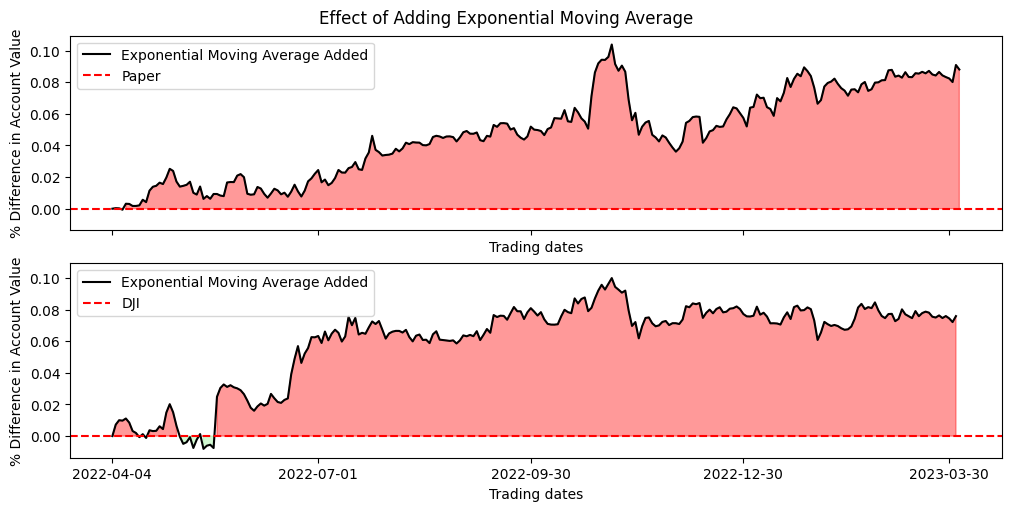

In [ ]:
#plot result for ema
initial_balance=1000000
key_dates=['2022-04-04','2022-07-01','2022-09-30','2022-12-30','2023-03-30']
ind="Exponential Moving Average"
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
#df_account_value_ema=pd.read_csv('/content/result/account_value_Exponential Moving Average.csv')
dates=df_account_value_ind['date']

#get DJI baseline
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value_ind.loc[0,'date'],
        end = df_account_value_ind.loc[len(df_account_value_ind)-1,'date'])
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ind['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji+.csv")

#get result of paper
df_account_value_paper=pd.read_csv('results/account_value_paper_baseline.csv')
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

#print(key_dates)
plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")


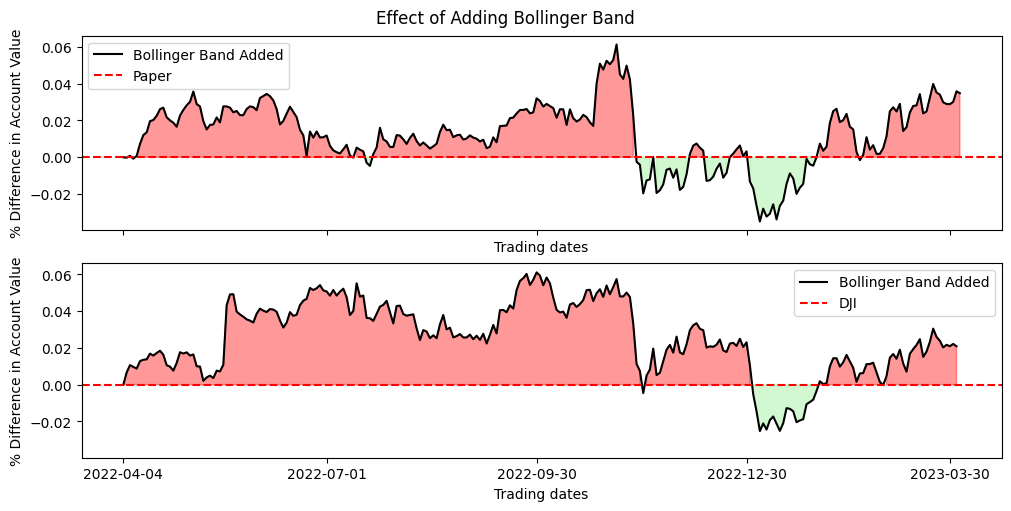

In [ ]:

ind='Bollinger Band'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")

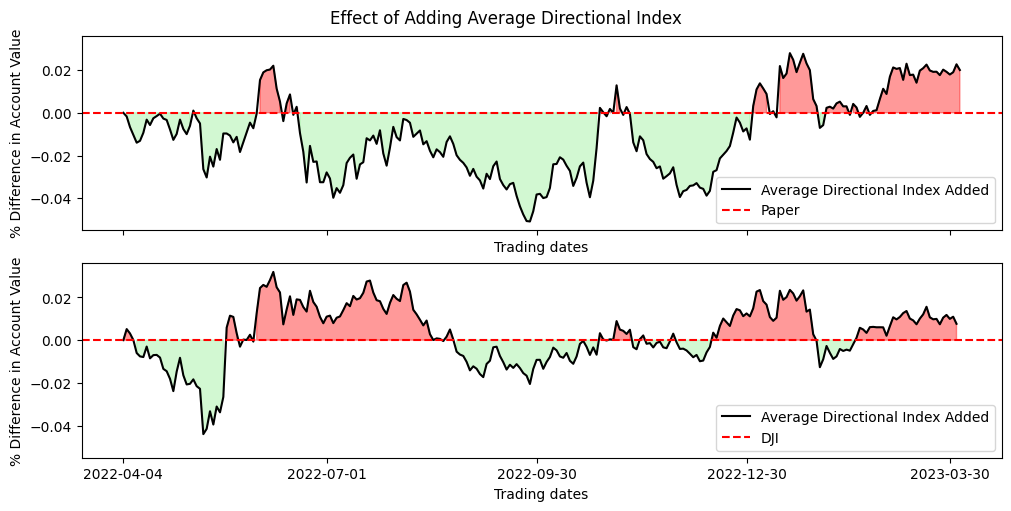

In [ ]:

ind='Average Directional Index'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")

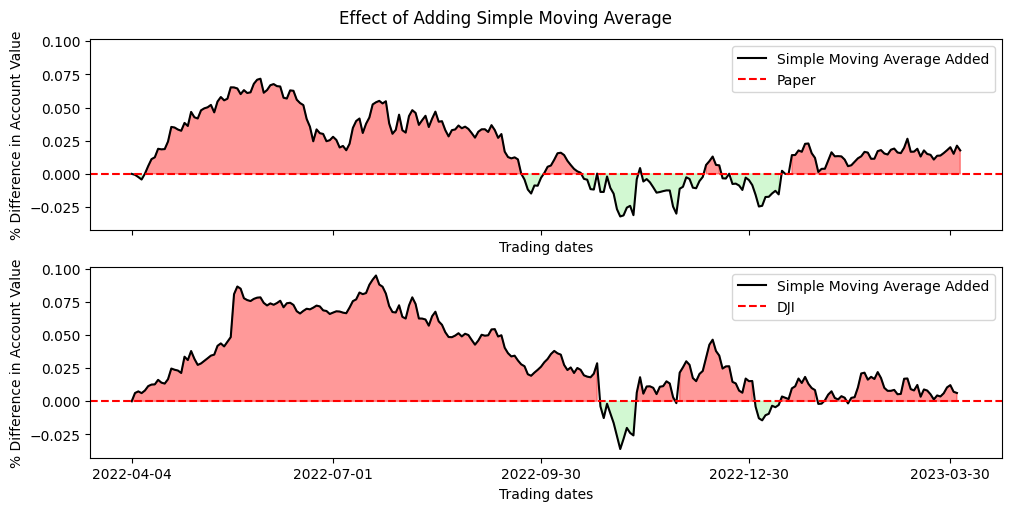

In [ ]:

ind='Simple Moving Average'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")


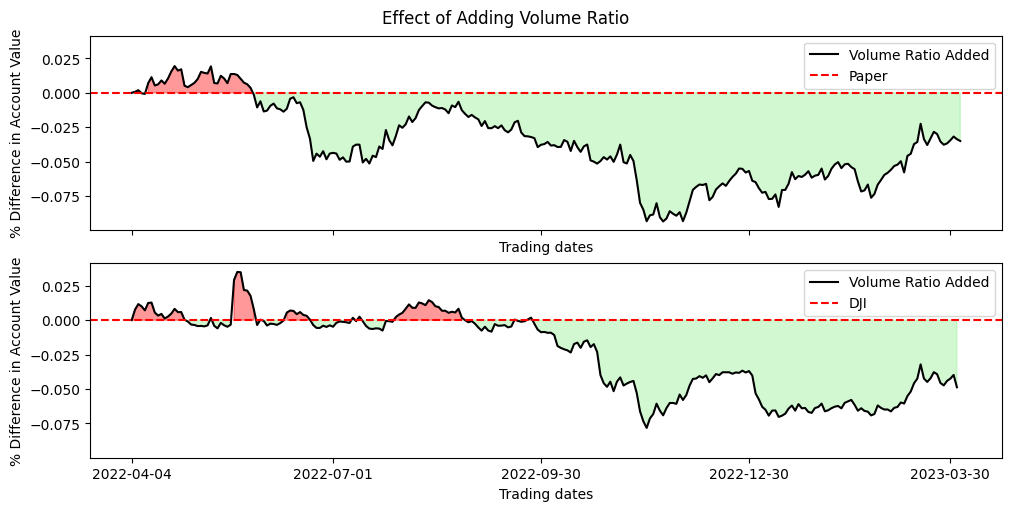

In [ ]:

ind='Volume Ratio'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")


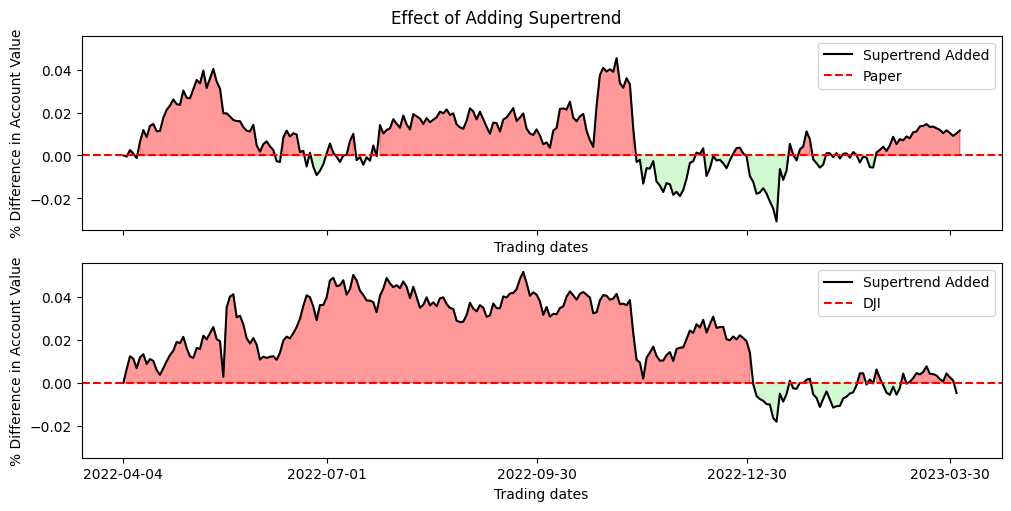

In [ ]:
ind='Supertrend'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance
plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")

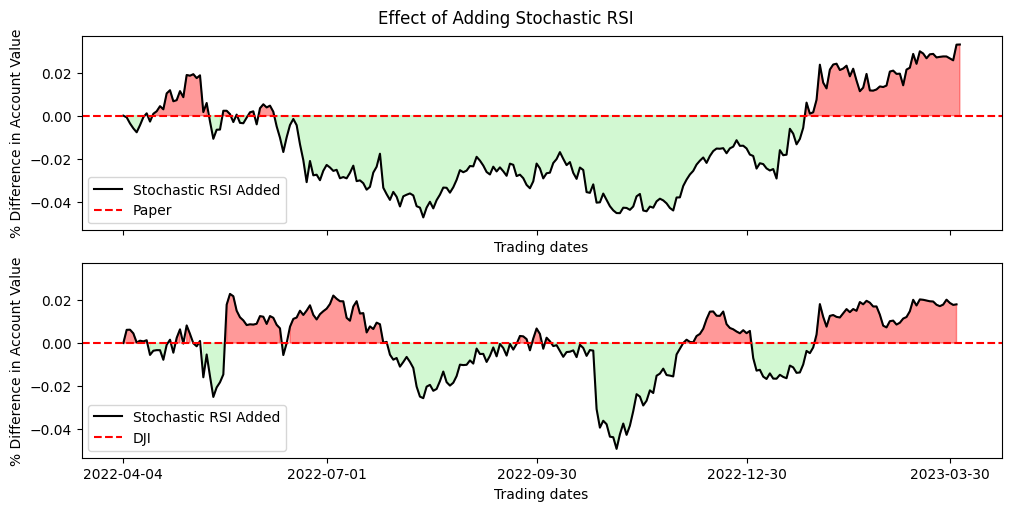

In [ ]:
#'Stochastic RSI','Triple Exponential Moving Average','Stochastic Oscillator'
ind='Stochastic RSI'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")


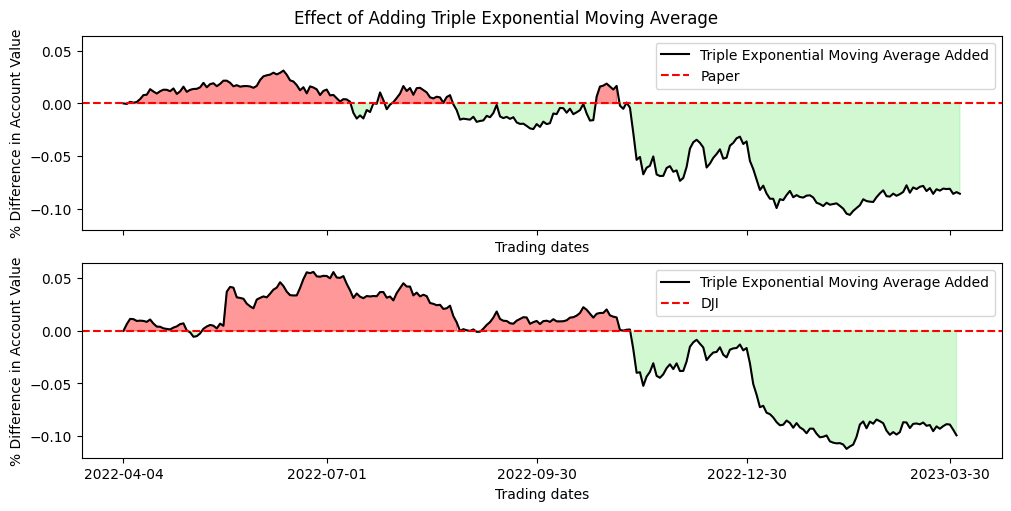

In [ ]:
#'Stochastic RSI','Triple Exponential Moving Average','Stochastic Oscillator'
ind='Triple Exponential Moving Average'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")


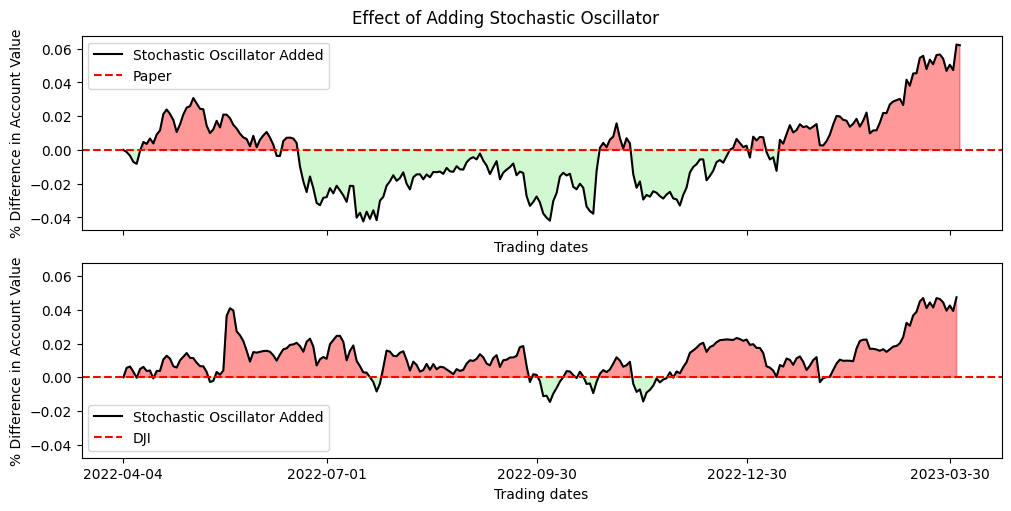

In [ ]:
#'Stochastic RSI','Triple Exponential Moving Average','Stochastic Oscillator'
ind='Stochastic Oscillator'
df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
diff_account_value_paper = (df_account_value_ind.account_value - df_account_value_paper.account_value)/initial_balance
diff_account_value_dji = (df_account_value_ind.account_value - df_dji.account_value)/initial_balance

plot_diff(diff_account_value_paper,diff_account_value_dji,dates,key_dates,"Effect of Adding "+ind,ind+" Added")


###Plot the curve for all indicators in one plot

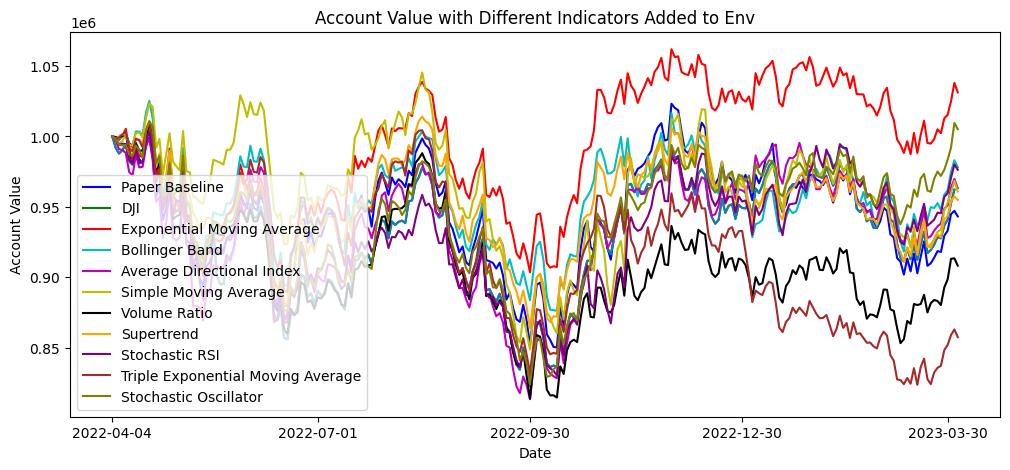

In [ ]:
%matplotlib inline
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'olive']
clr_idx=0
#plot base line
plt.figure(figsize=(12,5))
plt.plot(dates,df_account_value_paper.account_value,color=colors[clr_idx],label='Paper Baseline')
clr_idx+=1

#plot DJI
plt.plot(dates,df_dji.account_value,color=colors[clr_idx],label='DJI')
clr_idx+=1
plt.plot(dates,df_dji.account_value)
plt.xticks(key_dates)

for ind in additional_indicator_names:
  df_account_value_ind=pd.read_csv('results/account_value_{}.csv'.format(ind))
  plt.plot(dates,df_account_value_ind.account_value,color=colors[clr_idx],label=ind)
  clr_idx+=1

plt.title('Account Value with Different Indicators Added to Env')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.legend()
plt.show()



#6. Sentiment Analysis

Besides encoding technical indicators, which can be derived from the stock prices itself, into the environment, we also decided to encode sentiment analysis into the environment. This task is difficult for the following reasons:

1.   The time-sensitive nature of RL. Since we're always making progress in timeline, in our case, trading days, we need to get the sentiment results for every trade dates in our data set. This is diffcult because our RL agents requires stock data that span 5-6 years. Meaning we have to acquire the news for every trading date, perform sentiment analysis on them, and add the result to our data set
2. Market reacts quickly to news. Therefore we need to acquire the latest news for each company on each day (e.g cannot use the sentiment result for news that are 2 days ago)
3.    Different source of information. Human traders often make their decision based on many source of information such as news, twitter, tiktok, reddit. Its very different to acquire a set of comprehensive textual data for a given company on each day.

To do this, we
1. Acquire the stock data of Dow's 30 companies that spans certain time period (e.g 2020-01-01 to 2023-01-01) as usual.
2. Each row of our data contains the stock price for a given company on a given date (e.g 'Apple, $100, 2020-01-01'). We iterate through all rows, for each row:
  

  *   Acquire up to 100 relavent news of this company on this date (e.g all news about Apple on 2020-01-01) through `newsapi`
  *   Perform sentiment analysis on all the news/article we can acquire. For each of them, we obtain a real number ∈ [-1,1] representing the level of positiveness in the news. (e.g 'Apple releases new product' is considered as positive news)

*   We average over the sentiment result for each news/article and bind it to our data set (along with all other features such as stock prices for this company on this date)

Ideally, we want to acquire the sentiment results for every row of our data set (in total > 90,000 rows). However, the api we use to acquire news `newsapi` restricts the number of HTTPS requests we can sent (max 100 per day). Therefore we should theoretically be able to encode sentiment analysis into our environment and observe a noticeable different in RL agent's performance, but we are restricted by the amount of news we can obtain.

In the following blocks, we have demonstrated an example of how to acquire the sentiment results on a small section of stock data.








In [ ]:
!pip install yfinance
!pip install newsapi-python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, timedelta, datetime
import yfinance as yf

#display
#pd.set_option('display.max_colwidth',700)

import nltk
nltk.download('vader_lexicon')

from newsapi import NewsApiClient
#from newsapi.newsapi_client import NewsApiClient

from nltk.sentiment.vader import SentimentIntensityAnalyzer
SentAnalysis = SentimentIntensityAnalyzer()


KEY = 'dc92d1b00ece4fda9b378c160b4ff12e' #we're using the free account. With limits the number of requests we can send per day

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#Example of how we can acquire news on certain company
#https://newsapi.org/docs/endpoints/everything
keyword = 'apple'
date = date.today() - timedelta(days=1)
newsapi = NewsApiClient(api_key= KEY)

articles = newsapi.get_everything(q = keyword,
                                      from_param = date.isoformat(),
                                      to = (date + timedelta(days = 1)).isoformat(),
                                      language="en",
                                      #sources = ",".join(sources_list),
                                      sort_by="relevancy",
                                      page_size = 100)

#print articles -- uncomment below
articles

{'status': 'ok',
 'totalResults': 15,
 'articles': [{'source': {'id': None, 'name': 'Yanko Design'},
   'author': 'Vincent Nguyen',
   'title': 'First Time Using the Apple Vision Pro: It Blew My Mind',
   'description': 'First Time Using the Apple Vision Pro: It Blew My MindFrom the moment I set my eyes on the Apple Vision Pro, the intuitive nature of its interface struck me. Controlling the device through natural...',
   'url': 'https://www.yankodesign.com/2024/04/17/first-time-using-the-apple-vision-pro-it-blew-my-mind/',
   'urlToImage': 'https://www.yankodesign.com/images/design_news/2024/04/eye-opening-magic-as-the-apple-vision-pro-blew-my-mind/apple-vision-pro-3.jpg',
   'publishedAt': '2024-04-18T00:30:04Z',
   'content': 'From the moment I set my eyes on the Apple Vision Pro, the intuitive nature of its interface struck me. Controlling the device through natural gestureslike tapping fingers together for selection or p… [+5398 chars]'},
  {'source': {'id': None, 'name': 'Idownlo

In [ ]:
#Acquires the top 100 relavent news on a certain company and perform sentiment analysis on the news
def fetch_articles_sent(ticker, start_date, show_all_articles = False):
  #gets the article for a specific ticker on start_date
  newsapi = NewsApiClient(api_key= KEY)
  if type(start_date) == str:
    date = datetime.strptime(start_date,'%Y-%m-%d')
  else:
    date = start_date
  # business_en_sources = get_sources('business','en')
  articles = newsapi.get_everything(q = ticker,
                                    from_param = date.isoformat(),
                                    to = (date + timedelta(days = 1)).isoformat(),
                                    language="en",
                                    sort_by="relevancy",
                                    page_size = 100)
  contents = ''
  sept = set()

  dates = {}
  dates_list = []

  for article in articles['articles']:

    if str(article['title']) in sept:
      continue

    else:
      sept.add(str(article['title']))
      contents = str(article['title']) + '. ' + str(article['description'])
      sentiment = SentAnalysis.polarity_scores(contents)['compound']
      dates.setdefault(date, []).append(sentiment)
      dates_list.append((sentiment, article['url'], article['title'], article['description']))

  date_sentiments_l = sorted(dates_list, key=lambda tup: tup[0], reverse = True)
  #sent_list = list(dates.values())[0]

  return pd.DataFrame(dates_list, columns=['Sentiment','URL','Title','Description'])

Example of acquiring the result of sentiment analysis on the up to 100 relavent news on Apple Inc on a particular date (yesterday)

0.21523333333333333


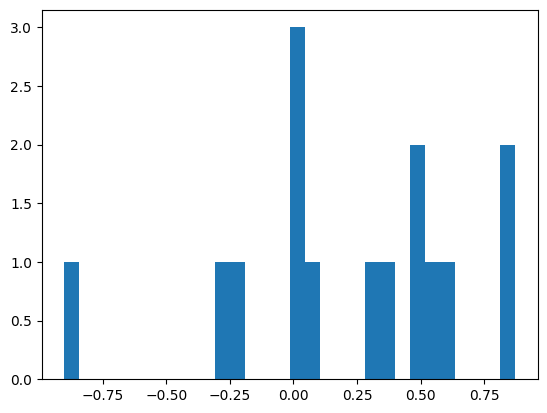

In [ ]:
%matplotlib inline
date1 = date.today() - timedelta(days=1)

return_articles = fetch_articles_sent(ticker= 'Apple', start_date = date1 , show_all_articles = True)
print(return_articles.Sentiment.mean()) #Average sentiments of all the news

# print(return_articles.Sentiment.count())
# print(return_articles.Description)
#return_articles.Sentiment.hist(bins=30, grid=False)
plt.hist(return_articles.Sentiment,bins=30) #plotting the distribution of sentiments
plt.show()

##Example of binding sentiment analysis to our stock dataset.

Note: Since we can only send 100 requests per day with a free account, we're only getting the stock data for the past day (30 stocks). But theoretically, we can obtain the sentiment analysis for stock data spanning years.

In [ ]:
#Get the stock dataset yesterday
print(DOW_30_TICKER)

STOCK_END_DATE = date.today() - timedelta(days=1)
STOCK_START_DATE = STOCK_END_DATE - timedelta(days=1)


df = YahooDownloader(start_date = STOCK_START_DATE,
                     end_date = STOCK_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Shape of DataFrame:  (30, 8)


###Stock data before sentiment analysis are added

In [ ]:
#example of stock data before sentiment results are added
df

,date,open,high,low,close,volume,tic,day
0,2024-04-17,169.610001,170.649994,168.000000,168.000000,50901200,AAPL,2
1,2024-04-17,267.540009,268.769989,263.390015,264.070007,2175100,AMGN,2
2,2024-04-17,219.559998,220.279999,216.520004,217.669998,2256800,AXP,2
3,2024-04-17,170.000000,170.850006,168.119995,170.210007,8162600,BA,2
4,2024-04-17,362.649994,362.910004,352.880005,358.320007,2313800,CAT,2
5,2024-04-17,277.739990,278.970001,274.839996,276.320007,4199400,CRM,2
6,2024-04-17,48.000000,48.279999,47.709999,47.790001,14407600,CSCO,2
7,2024-04-17,155.990005,157.710007,155.639999,156.399994,6733900,CVX,2
8,2024-04-17,114.000000,114.209999,112.889999,112.940002,7379000,DIS,2
9,2024-04-17,57.169998,57.360001,56.669998,56.820000,2815400,DOW,2


In [ ]:
#match ticker symbol to the name of the company commonly used in news
ticker_to_name={}
for ticker in DOW_30_TICKER:
  company_name=yf.Ticker(ticker).info['shortName']
  if company_name.endswith(' (The)'):
    company_name = company_name[:-len(' (The)')]
  if company_name.endswith('Inc'):
    company_name = company_name[:-len('Inc')]
  if company_name.endswith('Company'):
    company_name = company_name[:-len('Company')]
  if company_name.endswith(', Inc'):
    company_name = company_name[:-len(', Inc')]
  if company_name.endswith(' Inc.'):
    company_name = company_name[:-len(', Inc')]
  ticker_to_name[ticker] = company_name
  #ticker_to_name[ticker] =
print(ticker_to_name)

{'AXP': 'American Express ', 'AMGN': 'Amgen', 'AAPL': 'Apple', 'BA': 'Boeing ', 'CAT': 'Caterpillar,', 'CSCO': 'Cisco Systems,', 'CVX': 'Chevron Corporation', 'GS': 'Goldman Sachs Group,', 'HD': 'Home Depot,', 'HON': 'Honeywell International', 'IBM': 'International Business Machines', 'INTC': 'Intel Corporation', 'JNJ': 'Johnson & Johnson', 'KO': 'Coca-Cola ', 'JPM': 'JP Morgan Chase & Co.', 'MCD': "McDonald's Corporation", 'MMM': '3M ', 'MRK': 'Merck & Company,', 'MSFT': 'Microsoft Corporation', 'NKE': 'Nike,', 'PG': 'Procter & Gamble ', 'TRV': 'The Travelers Companies,', 'UNH': 'UnitedHealth Group Incorporated', 'CRM': 'Salesforce,', 'VZ': 'Verizon Communications', 'V': 'Visa', 'WBA': 'Walgreens Boots Alliance,', 'WMT': 'Walmart', 'DIS': 'Walt Disney ', 'DOW': 'Dow'}


In [ ]:

def add_sentiment_results(row):
  #computes the sentiments results for this ticker on this date
  articles_ticker=return_articles = fetch_articles_sent(ticker= ticker_to_name[row.tic], start_date = row.date , show_all_articles = True)
  return articles_ticker.Sentiment.mean()

df['sentiment_results']=df.apply(add_sentiment_results, axis=1)

###Stock data after sentiment analysis are added

In [ ]:
df

,date,open,high,low,close,volume,tic,day,sentiment_results
0,2024-04-17,169.610001,170.649994,168.000000,168.000000,50901200,AAPL,2,0.342631
1,2024-04-17,267.540009,268.769989,263.390015,264.070007,2175100,AMGN,2,0.407010
2,2024-04-17,219.559998,220.279999,216.520004,217.669998,2256800,AXP,2,0.326765
3,2024-04-17,170.000000,170.850006,168.119995,170.210007,8162600,BA,2,0.115674
4,2024-04-17,362.649994,362.910004,352.880005,358.320007,2313800,CAT,2,0.262356
5,2024-04-17,277.739990,278.970001,274.839996,276.320007,4199400,CRM,2,0.539886
6,2024-04-17,48.000000,48.279999,47.709999,47.790001,14407600,CSCO,2,0.233165
7,2024-04-17,155.990005,157.710007,155.639999,156.399994,6733900,CVX,2,0.275582
8,2024-04-17,114.000000,114.209999,112.889999,112.940002,7379000,DIS,2,0.262163
9,2024-04-17,57.169998,57.360001,56.669998,56.820000,2815400,DOW,2,0.152224


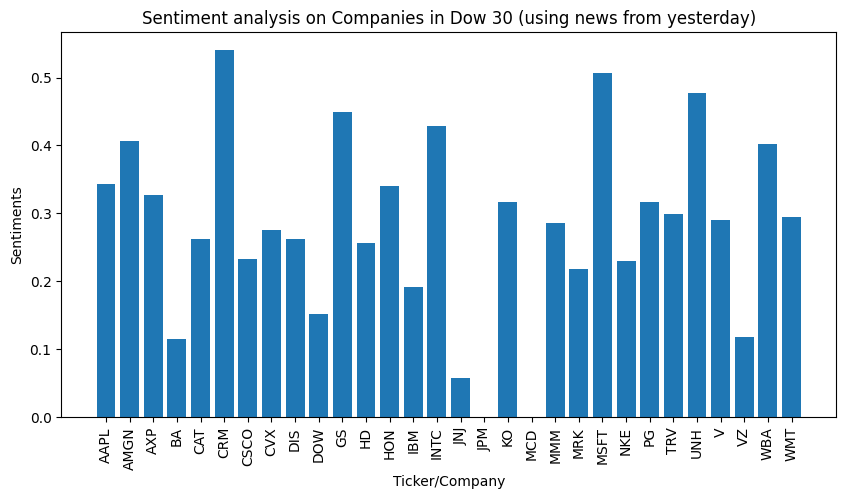

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(df.tic,df.sentiment_results)
plt.xticks(rotation=90)
plt.ylabel('Sentiments')
plt.xlabel('Ticker/Company')
plt.title('Sentiment analysis on Companies in Dow 30 (using news from yesterday)')
plt.show()